# Color segments

A notebook for testing how we can extract color segments arbitrary images. First let's download and read an image.

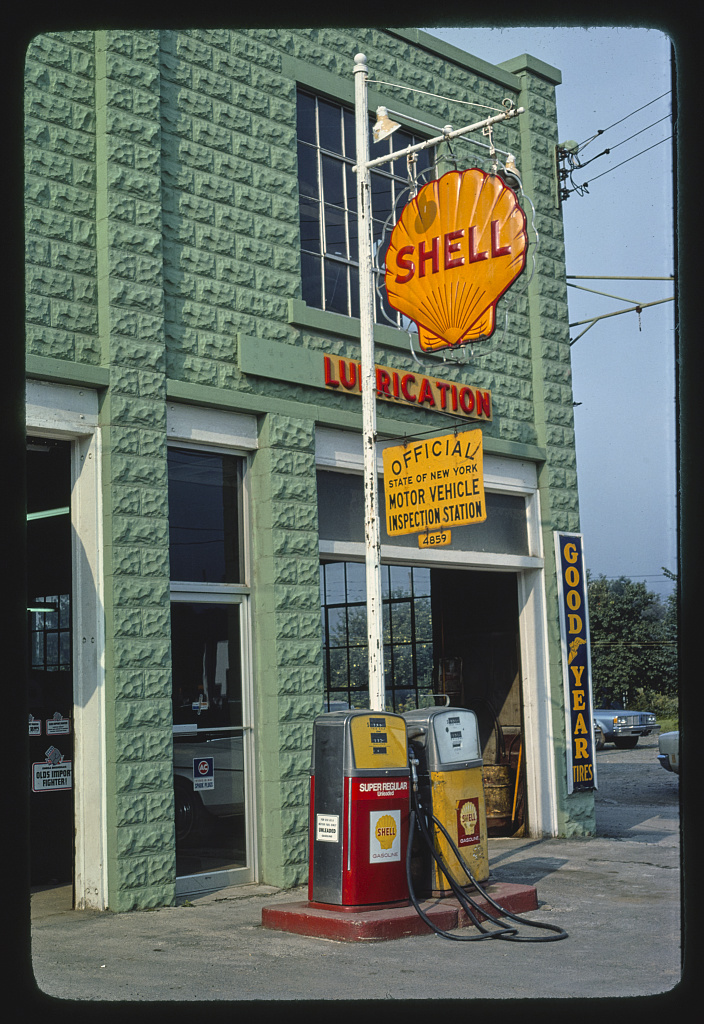

In [1]:
from IPython.display import display
from color_helpers import *

# Source: https://www.loc.gov/resource/mrg.01647/
image_url = "https://tile.loc.gov/storage-services/service/pnp/mrg/01600/01647v.jpg"
im = get_image_from_url(image_url)
display(im)

Now let's get the most dominant colors (adapted from [this notebook](https://github.com/LibraryOfCongress/data-exploration/blob/master/loc.gov%20JSON%20API/Dominant%20colors.ipynb))

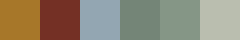

In [2]:
n = 6
order_by = 'saturation'
brightness_range = (0.25, 0.8)
saturation_range = (0.5, 1.0)
colors = get_dominant_colors(im, n, order_by, brightness_range, saturation_range)
palette = draw_colors(colors)
display(palette)

Next, select the first color and find the largest connected sectionS of the image with that color, and highlight the centroids.

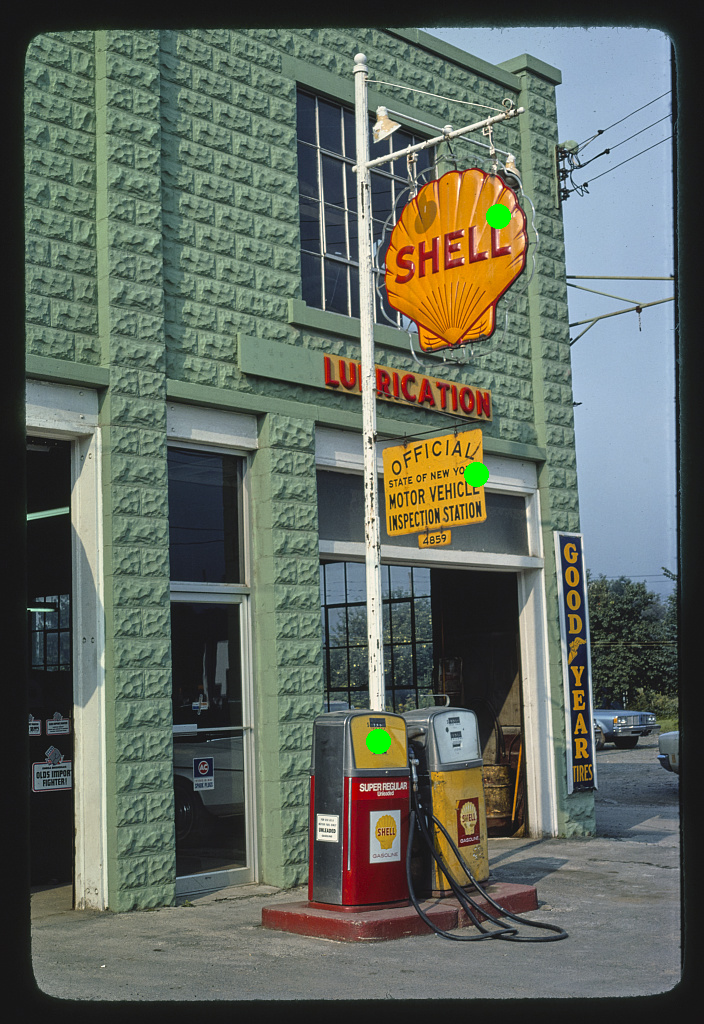

In [4]:
from PIL import ImageDraw
first_color = colors[0]
segments = get_segments_from_color(im, first_color)
image_with_centroids = im.copy()
draw = ImageDraw.Draw(image_with_centroids)
for segment in segments:
    draw.circle(segment["centroid"], radius=12, fill="#00FF00")
display(image_with_centroids)

Next, let's download the Efficient SAM model, unzip, and build it.

In [ ]:
from efficient_sam.build_efficient_sam import build_efficient_sam_vits
import os
import zipfile
from segment_helpers import *

destination = "weights/efficient_sam_vits.pt.zip"
if not os.path.isfile("weights/efficient_sam_vits.pt"):
    weight_url = "https://github.com/yformer/EfficientSAM/raw/refs/heads/main/weights/efficient_sam_vits.pt.zip"
    download_file(weight_url, destination)
    with zipfile.ZipFile(destination, 'r') as zip_ref:
        zip_ref.extractall("weights")
efficient_sam_vits_model = build_efficient_sam_vits()
efficient_sam_vits_model.eval()
print("Ready to segment.")

Next, segment everything and show the masks

In [ ]:
cached_masks = "tmp/mask_efficient_sam_vits.npy"
cache = True
mask_efficient_sam_vits = None
if cache and not os.path.isfile(cached_masks):
    mask_efficient_sam_vits = get_all_masks(im, efficient_sam_vits_model)
    # Cache it to save time on re-runs
    with open(cached_masks, 'wb') as f:
        np.save(f, mask_efficient_sam_vits)
else:
    mask_efficient_sam_vits = np.load(cached_masks)
color_masks = show_color_masks(im, mask_efficient_sam_vits)
display(color_masks)

Next, let's loop through each segment, find the dominant color, and see if that color is close to one of the colors in our palette.

In [ ]:
import math

mask_count, h, w = mask_efficient_sam_vits.shape
cols = 6
rows = int(math.ceil(1.0 * mask_count / cols))

for i in range(mask_count):
    mask = mask_efficient_sam_vits[i]
    